# Bikeshare Data Analysis

<h2>Setting up Environment</h2>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import time
import numpy as np
import datetime
from dateutil import parser
%matplotlib inline

In [2]:
#reads Bikeshare csv as dataframe
Bikeshare = pd.read_csv('C:\\Users\\kmoore\\Desktop\\Data Sets\\Bikeshare\\train.csv')

#preview of data
Bikeshare.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


<pre>
datetime - hourly date + timestamp
season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
holiday - whether the day is considered a holiday
workingday - whether the day is neither a weekend nor holiday
weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy 
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
temp - temperature in Celsius
atemp - "feels like" temperature in Celsius
humidity - relative humidity
windspeed - wind speed
casual - number of non-registered user rentals initiated
registered - number of registered user rentals initiated
count - number of total rentals

</pre>

In [3]:
#preview of dependent variables

BikeshareDeps = pd.concat([Bikeshare['count'], Bikeshare['registered'], Bikeshare['casual']], axis=1)
BikeshareDeps.describe()

,count,registered,casual
count,10886.000000,10886.000000,10886.000000
mean,191.574132,155.552177,36.021955
std,181.144454,151.039033,49.960477
min,1.000000,0.000000,0.000000
25%,42.000000,36.000000,4.000000
50%,145.000000,118.000000,17.000000
75%,284.000000,222.000000,49.000000
max,977.000000,886.000000,367.000000


<br><h2>Formatting and Feature Engineering</h2>

In [4]:
#converts temp & atemp from Celsius to Fahrenheit
Bikeshare['temp']=Bikeshare['temp']*9/5+32
Bikeshare['atemp']=Bikeshare['atemp']*9/5+32

In [5]:
#breaks datetime into date and hour (as int) columns
Bikeshare["date"] = Bikeshare.datetime.apply(lambda x : x.split()[0])
Bikeshare["hour"] = Bikeshare.datetime.apply(lambda x : x.split()[1].split(":")[0])

Bikeshare["hour"]=Bikeshare["hour"].astype(int)


#adds columns for AM, PM, and combined rush hour (6-10AM and 4-8PM respectively) 
AMR=[]    
for x in range(0,len(Bikeshare['hour'])):
    if Bikeshare['hour'][x] in range(6,10) and Bikeshare['workingday'][x]==1:
        AMR.append(1)
    else:
        AMR.append(0)

PMR=[]    
for x in range(0,len(Bikeshare['hour'])):
    if Bikeshare['hour'][x] in range (16,20) and Bikeshare['workingday'][x]==1:
        PMR.append(1)
    else:
        PMR.append(0)        
        
Rush=[]
for x in range(0,len(PMR)):
    if AMR[x]==1 or PMR[x]==1:
        Rush.append(1)
    else:
        Rush.append(0)

Bikeshare["AMrush"]=AMR
Bikeshare["PMrush"]=PMR
Bikeshare["rushHour"]=Rush

In [6]:
#adds month
import calendar
Bikeshare["month"] = Bikeshare.date.apply(lambda dateString : calendar.month_name[datetime.datetime.strptime(dateString,"%Y-%m-%d").month])

#adds day of the week
Bikeshare["weekday"] = Bikeshare.date.apply(lambda dateString : calendar.day_name[datetime.datetime.strptime(dateString,"%Y-%m-%d").weekday()])

In [7]:
#drops datetime
Bikeshare = Bikeshare.drop(['datetime'],axis=1)

<h5>Creating dummy variables for regression</h5>

In [8]:
#creates dummy variables for seasons
dummy_seasons=pd.get_dummies(Bikeshare['season'])
Bikeshare['spring']=dummy_seasons[1]
Bikeshare['summer']=dummy_seasons[2]
Bikeshare['fall']=dummy_seasons[3]
Bikeshare['winter']=dummy_seasons[4]

#creates dummy variables for weather
dummy_weather=pd.get_dummies(Bikeshare['weather'])
Bikeshare['weather1']=dummy_weather[1]
Bikeshare['weather2']=dummy_weather[2]
Bikeshare['weather3']=dummy_weather[3]
Bikeshare['weather4']=dummy_weather[4]

#creates dummy variables for day of the week
dummy_day=pd.get_dummies(Bikeshare['weekday'])
Bikeshare['Monday']=dummy_day['Monday']
Bikeshare['Tuesday']=dummy_day['Tuesday']
Bikeshare['Wednesday']=dummy_day['Wednesday']
Bikeshare['Thursday']=dummy_day['Thursday']
Bikeshare['Friday']=dummy_day['Friday']
Bikeshare['Saturday']=dummy_day['Saturday']
Bikeshare['Sunday']=dummy_day['Sunday']

#creates dummy variables for month of the year
dummy_month=pd.get_dummies(Bikeshare['month'])
Bikeshare['Jan']=dummy_month['January']
Bikeshare['Feb']=dummy_month['February']
Bikeshare['Mar']=dummy_month['March']
Bikeshare['Apr']=dummy_month['April']
Bikeshare['May']=dummy_month['May']
Bikeshare['Jun']=dummy_month['June']
Bikeshare['Jul']=dummy_month['July']
Bikeshare['Aug']=dummy_month['August']
Bikeshare['Sep']=dummy_month['September']
Bikeshare['Oct']=dummy_month['October']
Bikeshare['Nov']=dummy_month['November']
Bikeshare['Dec']=dummy_month['December']

#hour dummys
dummy_hour=pd.get_dummies(Bikeshare['hour'])
for x in Bikeshare['hour']:
    Bikeshare['hour'+str(x)]=dummy_hour[x]
    
#creates a numbered index
Bikeshare['index']=range(0,len(Bikeshare))

In [9]:
#groups dummy variables in a list
dummyList = ['spring','summer','winter','fall','weather1','weather2','weather3','weather4','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
miscList = ['index','date']
hourDummys=[]

for x in range (0,24):
    dummyList.append('hour'+str(x))
    hourDummys.append('hour'+str(x))
    
noMisc=Bikeshare.drop(miscList,axis=1)

noDummys=Bikeshare.drop(dummyList,axis=1)
noDummys=noDummys.drop(miscList,axis=1)

#creates a copy without outliers
noOutliers = Bikeshare[np.abs(Bikeshare['count']-Bikeshare['count'].mean())<=(3*Bikeshare['count'].std())]

In [10]:
print('shape with outliers: ',Bikeshare.shape)
print('shape without outliers: ',noOutliers.shape)

shape with outliers:  (10886, 70)
shape without outliers:  (10739, 70)


<h5>Splitting data into test and train sets</h5>

In [11]:
train=Bikeshare.sample(frac=0.8,random_state=200)
test=Bikeshare.drop(train.index)

In [12]:
print('Total set size: '+str(len(Bikeshare)))
print('Training set size: '+str(len(train)))
print('Testing set size: '+str(len(test)))

Total set size: 10886
Training set size: 8709
Testing set size: 2177


<br><h2>Visualizations</h2>

In [13]:
displaySet=0
displaySet=Bikeshare.drop(dummyList,axis=1)
displaySet=displaySet.drop(['index'],axis=1)
displaySet=displaySet.drop(['holiday','season','workingday','weather','temp','atemp','humidity','windspeed','hour','AMrush','PMrush','rushHour'],axis=1)

displaySet['Registered'] = displaySet.groupby('date')['registered'].transform(sum)
displaySet['Casual'] = displaySet.groupby('date')['casual'].transform(sum)
displaySet=displaySet.drop(['casual','registered','count'],axis=1)
displaySet=displaySet.drop_duplicates(['date'])

displaySet['index']=range(len(displaySet['date']))

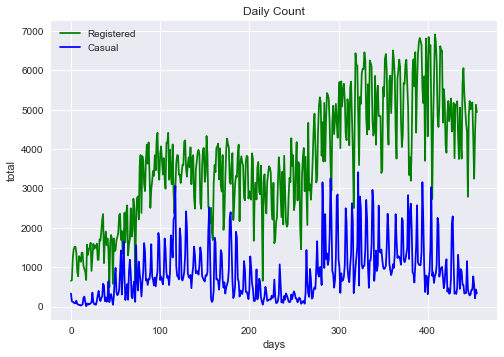

In [36]:
plt.plot(displaySet['index'],displaySet['Registered'],'g')
plt.plot(displaySet['index'],displaySet['Casual'],'b')
plt.xlabel('days')
plt.ylabel('total')
plt.legend()
plt.title('Daily Count')
plt.figure(figsize=(5,5))

plt.show()

<p>In the following graph we can see the most popular times of day for Capital Bikeshare:</p>

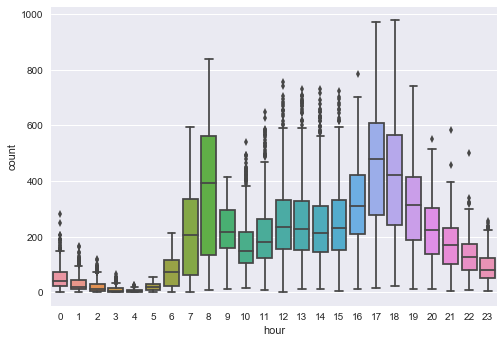

In [15]:
import seaborn as sns
sns.boxplot(data=Bikeshare,y="count",x="hour",orient="v")

<p><br><br>In the following graphs we can see the positive correlation between temperature and ridership.<br> We also notice that registered riders tend to ride more on working days with a large increase in ridership during rushhour, while casual riders are much more likely to ride on non-working days, with little change in ridership during rushhour:</p>

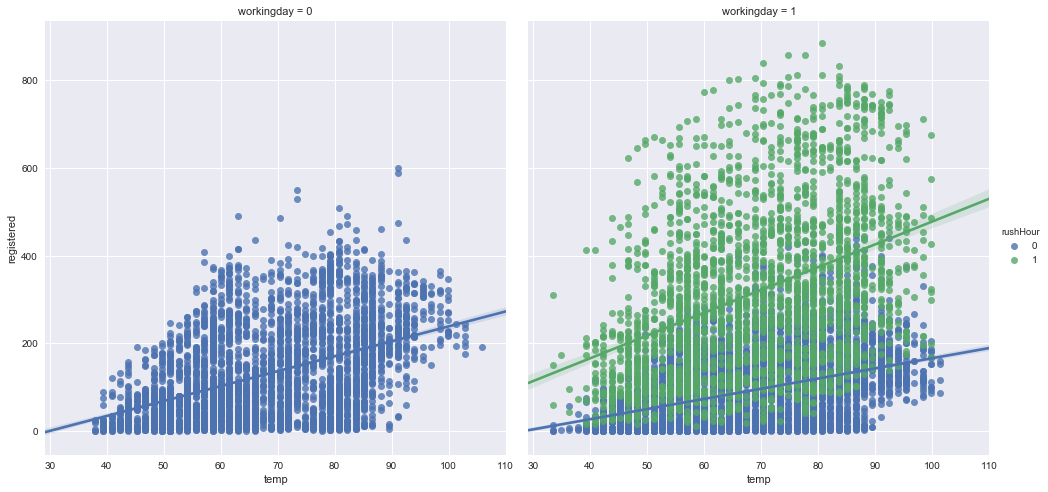

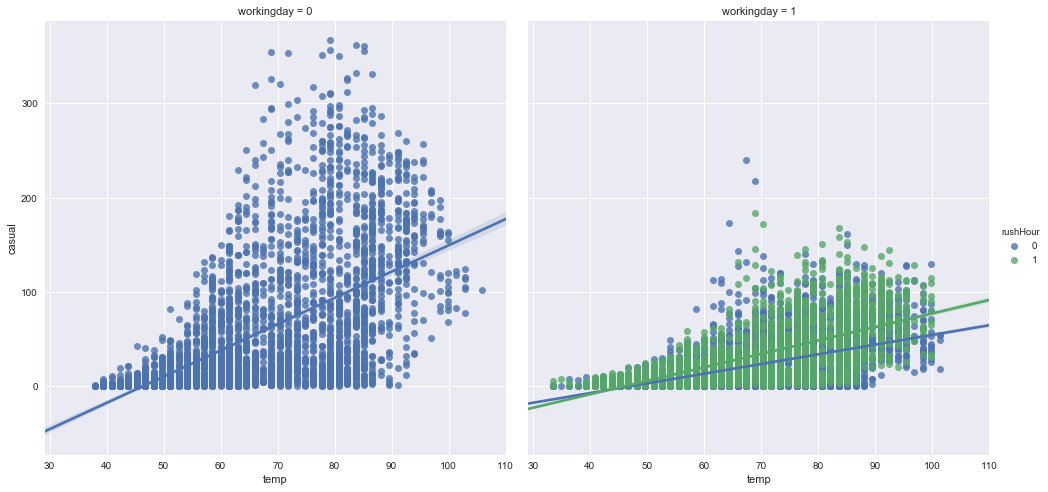

In [16]:
#Registered x Temp on working and non-working days
print(sns.lmplot("temp","registered", data=Bikeshare, col='workingday', hue='rushHour', fit_reg=True, size=7))
#Casual x Temp on working and non-working days
print(sns.lmplot("temp","casual", data=Bikeshare, col='workingday', hue='rushHour', fit_reg=True, size=7))

<h2> Linear Regression</h2>

<p>In this section I run a linear regression to model the training data:</p>

In [17]:
from sklearn import linear_model
lm = linear_model.LinearRegression()

In [18]:
Xtrain = train.drop(['casual','registered','count','rushHour','date','index','weekday','month','weather','season','hour'], axis = 1)
Ytrain = train['count']

Xtest = test.drop(['casual','registered','count','rushHour','date','index','weekday','month','weather','season','hour'], axis = 1)
Ytest = test['count']

regr = lm.fit(Xtrain,Ytrain)

In [33]:
fc = pd.DataFrame(list(zip(Xtrain.columns, regr.coef_)), columns = ['features','coefficients'])
fc = fc.sort_values(by=['coefficients'], ascending=[False])
fc.head(10)

,features,coefficients
20,Friday,1.114198e+13
19,Thursday,1.114198e+13
18,Wednesday,1.114198e+13
17,Tuesday,1.114198e+13
16,Monday,1.114198e+13
9,summer,4.853751e+11
10,fall,3.917163e+11
8,spring,3.464027e+11
12,weather1,3.063900e+11
13,weather2,3.063900e+11


In [20]:
#coefficient of determination (R^2 value)
RSQ = regr.score(Xtrain,Ytrain)
print('R^2 value: ' + str(RSQ))

#adjusted R^2
N=len(train['count'])
P=len(Xtrain.columns)
adjustedRSQ = RSQ-(1-RSQ)*(P/(N-P-1))
print('Adjusted R^2: '+str(adjustedRSQ))

#root mean squared error
mseFull = np.mean((Ytrain-lm.predict(Xtrain)) ** 2)
print('RMSE = '+ str(mseFull**0.5))

R^2 value: 0.711187394963
Adjusted R^2: 0.709217231511
RMSE = 97.0660739229512


<h2>Decision Tree Regression</h2>

<p>In this section I use a regression tree to predict total count based on independent variables.
I found that the most effective method of splitting was to limit splitting to nodes with 18 samples.</p>

In [24]:
from sklearn import tree

In [25]:
#setting up train data
trainVars=train.drop(['season','weekday','count','casual','registered','month','rushHour','hour'],axis=1)
trainVars=trainVars.drop(miscList,axis=1)
trainTarget = train["count"].values

#setting up test data
testVars=test.drop(['season','weekday','count','casual','registered','month','rushHour','hour'],axis=1)
testVars=testVars.drop(miscList,axis=1)
testTarget=test['count']

#creates tree
tree1 = tree.DecisionTreeRegressor(criterion='mse',min_samples_split=18,random_state=3)
tree1 = tree1.fit(trainVars, trainTarget)

In [26]:
#R^2
print('R^2 for train data: '+str(tree1.score(trainVars,trainTarget)))
print('R^2 for test data: '+str(tree1.score(testVars,testTarget)))

#root mean squared error
mseTrain = np.mean((trainTarget-tree1.predict(trainVars)) ** 2)
print('Train RMSE = '+ str(mseTrain**0.5))

#root mean squared error
mseTest = np.mean((testTarget-tree1.predict(testVars)) ** 2)
print('Test RMSE = '+ str(mseTest**0.5))

R^2 for train data: 0.908333398561
R^2 for test data: 0.778055869471
Train RMSE = 54.6845895819
Test RMSE = 86.23512712906873


<p>This method yielded an R-squared value of .908 for the train data and .778 for the test data.<br>
Mean squared error for the train data was 54.7, for the test data 86.2<br><br><br></p>

In [34]:
table = pd.DataFrame(list(zip(trainVars.columns, tree1.feature_importances_)), columns = ['features','importance'])
table = table.sort_values(by=['importance'], ascending=[False])
table.head(10)

,features,importance
8,PMrush,0.222478
5,humidity,0.109449
4,atemp,0.104377
3,temp,0.082761
44,hour8,0.063926
7,AMrush,0.063520
1,workingday,0.038841
52,hour16,0.024463
6,windspeed,0.018441
42,hour6,0.017700


Axes(0.125,0.125;0.775x0.755)


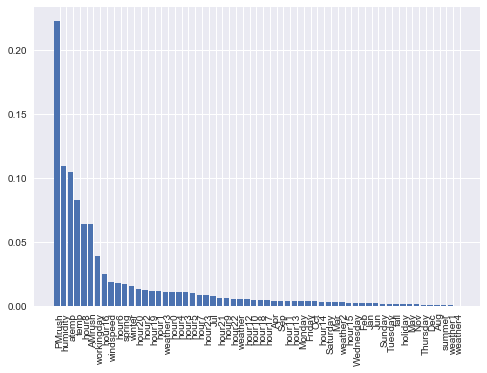

In [28]:
#plots DT feature importances
fig = plt.figure()
ax=plt.subplot(111)
width=.8

ax.bar(range(len(table['features'])),table['importance'],width=width)
ax.set_xticks(np.arange(len(table['features'])) + width/2)
ax.set_xticklabels(table['features'], rotation=90)

print(ax)

<h2>Random Forest</h2>

<p>In this section I use a random forest to more accurately estimate the test data. I found that the sweet spot for predictive accuracy was to limit node splitting to 11 or more samples</p>

In [29]:
from sklearn import ensemble
rf = ensemble.RandomForestRegressor(n_estimators = 10,random_state=2, min_samples_split = 11)

#fits forest to the training data
forest = rf.fit(trainVars,trainTarget)

In [30]:
#R^2
print('R^2 value for trian data: '+str(forest.score(trainVars,trainTarget)))
print('R^2 value for test data: '+str(forest.score(testVars,testTarget)))

#root mean squared error
mseTrain2 = np.mean((trainTarget-forest.predict(trainVars)) ** 2)
print('Train RMSE = '+ str(mseTrain2**0.5))

#root mean squared error
mseTest2 = np.mean((testTarget-forest.predict(testVars)) ** 2)
print('Test RMSE = '+ str(mseTest2**0.5))

R^2 value for trian data: 0.928244885872
R^2 value for test data: 0.833527597149
Train RMSE = 48.3822233203
Test RMSE = 74.68501969876968


<p>Ultimately, this technique yielded an R-squared value of .928 on the train data and .834 on the test data.<br>R^2 value was 48.382 for the train data and 74.685 for the test data<br><br><br></p>

In [35]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
indices = np.argsort(importances)

H = pd.DataFrame(list(zip(trainVars.columns, importances)), columns = ['features','importance'])
H = H.sort_values(by=['importance'], ascending=[False])
H.head(10)

,features,importance
8,PMrush,0.213317
4,atemp,0.113578
5,humidity,0.106050
3,temp,0.077979
7,AMrush,0.063379
44,hour8,0.059999
1,workingday,0.046634
52,hour16,0.021717
6,windspeed,0.019795
42,hour6,0.017800


Axes(0.125,0.125;0.775x0.755)


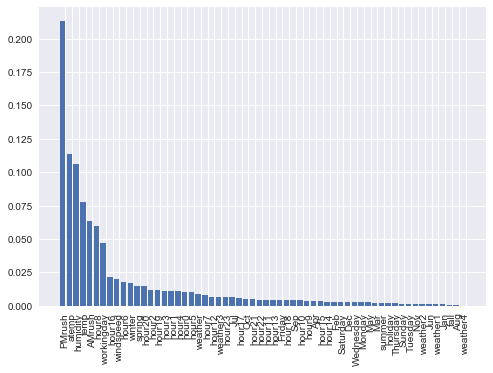

In [32]:
fig = plt.figure()
ax=plt.subplot(111)
width=.8

ax.bar(range(len(H['features'])),H['importance'],width=width)
ax.set_xticks(np.arange(len(H['features'])) + width/2)
ax.set_xticklabels(H['features'], rotation=90)

print(ax)